# **Building a model to detect no of people in the image with mask and no mask in Colab**

# **DATASET**

Since in the maskclassifier dataset, I found only 1476 images comprising of with mask and without mask people.

So I had to segregate those into train, test and validation set with following structure and now we have a balanced dataset with:

1.train_size = 906

2.validation_size = 285

3.test_size = 285

Here's the link to modified structured dataset

https://drive.google.com/open?id=12p3W-soXbHEZHDqtdRoY5xZtYY3o3xEs

I have also 4 spare people images for the testing in maskclassifier foler

#  My approach:
  1. Extracting people faces in the images from MTCNN face extraction
  2. Predicting those cropped images for wearing or not wearing mask and ultimately counting 


#1. MTCNN face extraction(Multi-task Cascaded Convolutional Network)
This model has three convolutional networks (P-Net, R-Net, and O-Net) and is able to outperform many face-detection benchmarks while retaining real-time performance


In [0]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
pip install mtcnn

In [0]:
# confirming mtcnn was installed correctly and importing scikit-image, matplotlib, glob library
import mtcnn
import skimage.io as io
import matplotlib.pyplot as plt
import glob

# print version
print(mtcnn.__version__)

0.1.0


**INSERT INPUT IMAGE AT THE BELOW**

Shape of image/array: (737, 1024, 3)
INPUT IMAGE


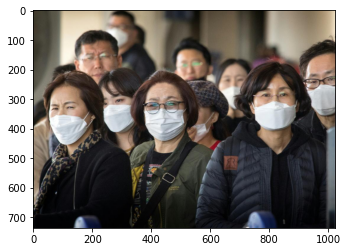

In [0]:
# load image from file
filename = "/content/drive/My Drive/maskclassifier/People3.jpg"
pixels = plt.imread(filename)
print("Shape of image/array:",pixels.shape)
pix_x, pix_y, cc =pixels.shape
print("INPUT IMAGE")
imgplot = plt.imshow(pixels)
#Showing the input image
plt.show()

In [0]:
# Deleting files from ROI folder if any file exists
for filepath in glob.iglob('/content/drive/My Drive/maskclassifier/ROI/*.png'):
    os.remove(filepath) if os.path.exists(filepath) else None

In [0]:
detector = mtcnn.MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
for face in faces:
    print(face)

{'box': [57, 279, 113, 135], 'confidence': 0.9999808073043823, 'keypoints': {'left_eye': (78, 335), 'right_eye': (125, 327), 'nose': (97, 359), 'mouth_left': (88, 385), 'mouth_right': (127, 377)}}
{'box': [628, 190, 95, 118], 'confidence': 0.9999687671661377, 'keypoints': {'left_eye': (656, 237), 'right_eye': (701, 237), 'nose': (676, 266), 'mouth_left': (659, 284), 'mouth_right': (694, 285)}}
{'box': [750, 226, 134, 159], 'confidence': 0.9999141693115234, 'keypoints': {'left_eye': (786, 288), 'right_eye': (848, 285), 'nose': (818, 316), 'mouth_left': (792, 348), 'mouth_right': (842, 347)}}
{'box': [165, 102, 113, 142], 'confidence': 0.9998131394386292, 'keypoints': {'left_eye': (192, 161), 'right_eye': (241, 156), 'nose': (217, 191), 'mouth_left': (202, 218), 'mouth_right': (241, 215)}}
{'box': [372, 241, 147, 196], 'confidence': 0.9989435076713562, 'keypoints': {'left_eye': (405, 327), 'right_eye': (472, 319), 'nose': (434, 365), 'mouth_left': (415, 396), 'mouth_right': (475, 392)}}


**MTCNN**

The neural network actually detects individual faces, locates facial landmarks (i.e. two eyes, nose, and endpoints of the mouth), and draws a bounding box around the face.

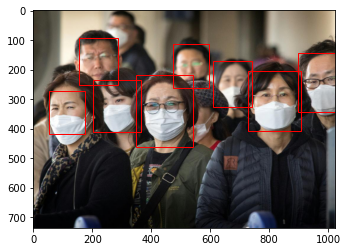

In [0]:
# draw an image with detected objects
def draw_facebox(filename, result_list):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    ROI_number=0
    scale=1.2
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # height=height*scale

        height +=2*(min(x,y)//10)
        width +=2*(min(x,y)//10)
        x -=(min(x,y)//10)
        y -=(min(x,y)//10)
        ROI = data[y:y+height, x:x+width]
        #Saving the face cropped region in ROI folder
        io.imsave('/content/drive/My Drive/maskclassifier/ROI/ROI_{}.png'.format(ROI_number), ROI)
        # create the shape
        rect = plt.Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        ROI_number += 1
    # show the plot
    plt.show()
faces = detector.detect_faces(pixels)
# display faces on the original image
draw_facebox(filename, faces)

# **2. Implementing a transfer learning solution to solve image classification problems to achieve higher accuracy**

In [0]:
# Base variables
import os, random
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image

# Input the location for the dataset here
base_dir = '/content/drive/My Drive/maskclassifier'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_widm_dir = os.path.join(train_dir, 'with_mask')
train_widoutm_dir = os.path.join(train_dir, 'without_mask')

train_size, validation_size, test_size = 906, 285, 285

img_width, img_height = 224, 224 

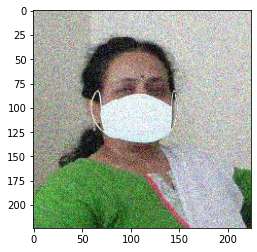

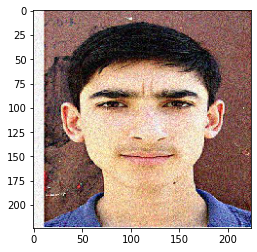

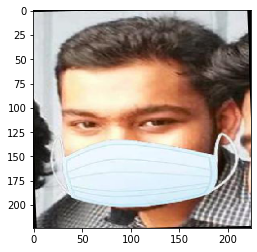

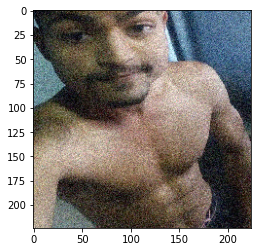

In [0]:
def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
#Showing any two random pictures from each of the two classes
for i in range(0,2):
    show_pictures(train_widm_dir)
    show_pictures(train_widoutm_di

We want to use a solution based on pre-trained models. We will use models that are composed of two parts:

**1.Convolutional base**

**2.Classifier**

My approach will use the convolutional base to extract features, using them to train a classifier to classify the input image as mask or without mask.


You can skip the below cells and run directly the **loading model** cell as I have already trained it for 100 epochs and saved


In [0]:
# Instantiate convolutional base
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

conv_base = InceptionResNetV2(weights='imagenet', 
                              include_top=False,
                              input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures

219062272/219055592 [==============================] - 2s 0us/step


*   **weights** initializes model's weights. Here we are saying that we want to use the same weights as ImageNet.
*   **include_top** as false means that we want to train our own classifier on top of the convolutional base.
*   **input_shape** defines the shape of the image tensors that will feed the network. We used the default input size of InceptionResNetV2 (229X229)



In [0]:
# Check architecture
conv_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_37[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

I went for InceptionResNetV2 because it had high accuracy and somewhat faster as compared to other model

![alt text](https://i.stack.imgur.com/d0iwP.png)

InceptionResNetV2 is the best possible CNN architecture that I have taken as convolutional base

In [0]:
# Extract features
import os, shutil
from keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
          rotation_range=40,
          width_shift_range=0.2,
          height_shift_range=0.2,
          rescale=1./255,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest')
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 5, 5, 1536))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
test_features, test_labels = extract_features(test_dir, test_size)
validation_features, validation_labels = extract_features(validation_dir, validation_size)

Found 906 images belonging to 2 classes.
Found 285 images belonging to 2 classes.
Found 285 images belonging to 2 classes.


In [0]:
# Define model
from keras import models
from keras import layers
from keras import optimizers

epochs = 100

model = models.Sequential()
model.add(layers.Flatten(input_shape=(5, 5, 1536)))
model.add(layers.Dense(256, activation='relu', input_dim=(5*5*1536)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_25 (Flatten)         (None, 38400)             0         
_________________________________________________________________
dense_85 (Dense)             (None, 256)               9830656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 257       
Total params: 9,830,913
Trainable params: 9,830,913
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [0]:
# Train model
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=(validation_features, validation_labels))

Train on 906 samples, validate on 285 samples
Epoch 1/100
906/906 [==============================] - 4s 4ms/step - loss: 2.0235 - acc: 0.9106 - val_loss: 0.3027 - val_acc: 0.9789
Epoch 2/100
906/906 [==============================] - 4s 4ms/step - loss: 0.4061 - acc: 0.9868 - val_loss: 0.4185 - val_acc: 0.9825
Epoch 3/100
906/906 [==============================] - 4s 4ms/step - loss: 0.2444 - acc: 0.9901 - val_loss: 1.3212 - val_acc: 0.9719
Epoch 4/100
906/906 [==============================] - 4s 4ms/step - loss: 0.1500 - acc: 0.9934 - val_loss: 0.8491 - val_acc: 0.9789
Epoch 5/100
906/906 [==============================] - 4s 4ms/step - loss: 0.1634 - acc: 0.9912 - val_loss: 0.8457 - val_acc: 0.9825
Epoch 6/100
906/906 [==============================] - 4s 4ms/step - loss: 0.0685 - acc: 0.9945 - val_loss: 0.3766 - val_acc: 0.9895
Epoch 7/100
906/906 [==============================] - 4s 4ms/step - loss: 4.5560e-04 - acc: 1.0000 - val_loss: 0.5638 - val_acc: 0.9860
Epoch 8/100
906/906

# Using the above model, I have achieved validation accuracy of **99.65%**

In [0]:
# Save model
model.save('/content/drive/My Drive/maskclassifier/mask_classifier.h5')

In [0]:
# Loading model
from keras.models import load_model
model = load_model('/content/drive/My Drive/maskclassifier/mask_classifier.h5')

# **Model evaluation**

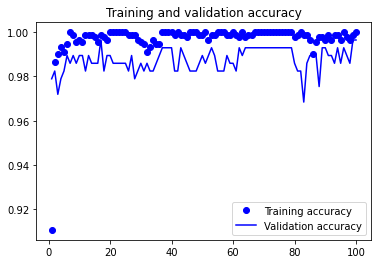

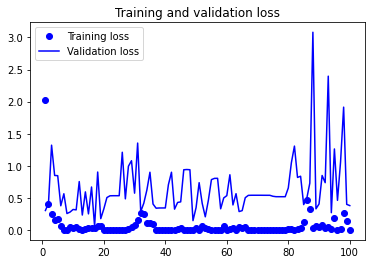

In [0]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **MODEL IN ACTION**

In [0]:
# Define function to visualize predictions

def visualize_predictions(classifier):
  global p
  global q
  for filepath in glob.iglob('/content/drive/My Drive/maskclassifier/ROI/*.png'):
    # Get picture
    img = image.load_img(filepath, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

    # Extract features
    features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

    # Make prediction
    try:
        prediction = classifier.predict(features)
    except:
        prediction = classifier.predict(features.reshape(1, 5*5*1536))

    # Show picture
    plt.imshow(img_tensor)
    plt.show()
    
    # Write prediction
    if prediction < 0.5:
        p=p+1
        print('With mask')
    else:
        q=q+1
        print('without mask')

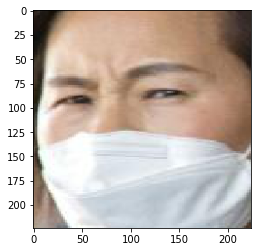

With mask


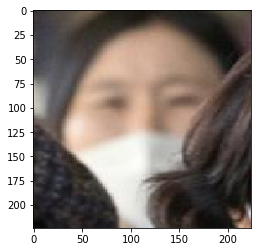

With mask


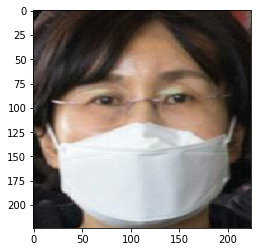

With mask


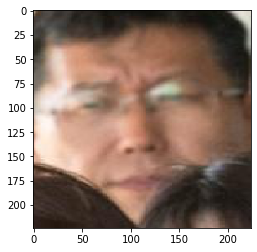

without mask


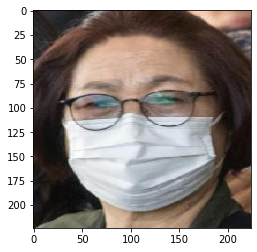

With mask


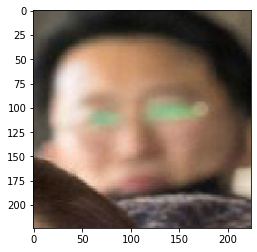

without mask


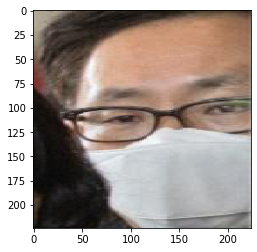

With mask


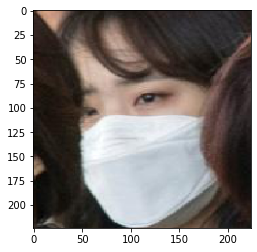

With mask



TOTAL NUMBER OF PEOPLE DETECTED WITH MASK: 6
TOTAL NUMBER OF PEOPLE DETECTED WITHOUT MASK: 2


In [0]:
# Visualize predictions
global p
global q
p=q=0
visualize_predictions(model)
print('\n\n')
print("TOTAL NUMBER OF PEOPLE DETECTED WITH MASK: {}".format(p))
print("TOTAL NUMBER OF PEOPLE DETECTED WITHOUT MASK: {}".format(q))

# **SUGGESTIONS**

The dataset which you sent me **maskclassifier** had images with people having only white masks.

So in order to have higher accuracy, we need much more diverse dataset such as images consisting of people wearing different colors of masks and people of different age groups.

Few real world dataset I have found upon searching for a bit.

Below, I have attached those datasets links

For Unmasked faces - https://github.com/aicip/UTKFace

For Masked faces - https://drive.google.com/open?id=1kZAIiv34Iav9Vt8BB101FXo4KoEClpx9